In [1]:
# Used to pull data from Reddit
import praw
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import re
import nltk
from pdpbox import pdp, get_dataset, info_plots

from google.cloud import bigquery

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import model_selection
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn import pipeline

import warnings
warnings.filterwarnings("ignore")

#nltk.download('punkt')

W0802 22:58:47.186151 140413857195840 deprecation_wrapper.py:119] From /home/armand_kok/anaconda3/lib/python3.7/site-packages/bert/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



# Data Pre-Processing

In [328]:
def cleanText(text):
    
    def replace_contraction(text):
        contraction_patterns = [(r'won\'t', 'will not'), (r'can\'t', 'can not'), (r'i\'m', 'i am'), (r'ain\'t', 'is not'), (r'(\w+)\'ll', '\g<1> will'), (r'(\w+)n\'t', '\g<1> not'),
                                (r'(\w+)\'ve', '\g<1> have'), (r'(\w+)\'s', '\g<1> is'), (r'(\w+)\'re', '\g<1> are'), (r'(\w+)\'d', '\g<1> would'), (r'&', 'and'), (r'dammit', 'damn it'), (r'dont', 'do not'), (r'wont', 'will not') ]
        patterns = [(re.compile(regex), repl) for (regex, repl) in contraction_patterns]
        for (pattern, repl) in patterns:
            (text, count) = re.subn(pattern, repl, text)
        return text

    def replace_links(text, filler=' '):
        text = re.sub(r'((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\.([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*',
                          filler, text).strip()
        return text

    def remove_numbers(text):
        text = ''.join([i for i in text if not i.isdigit()])
        return text
    
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = replace_contraction(text)
    text = replace_links(text, "link")
    #text = remove_numbers(text)
    text = re.sub(r'[,!@#$%^&*)(|/><";:.?\'\\}{]',"",text)
    text = strip_symbols(text)
    text = text.lower()
    return text

def stemmer(word):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    word = lemmatizer.lemmatize(word)
    return word

In [3]:
# Read .sql that pulls comments
fd = open('posts.sql', 'r')
post_sql = fd.read()
fd.close()

post_df = pd.read_gbq(post_sql,
                      project_id='w266-240122',
                      dialect='standard')

# Convert date into proper date/time
post_df['created_dt_tm'] = post_df['created_utc'].apply(lambda x: dt.datetime.fromtimestamp(x))

# Create field for month
post_df['created_dt_month'] = post_df['created_dt_tm'].dt.to_period('M').dt.to_timestamp()

In [8]:
# Filter only to post titles and it's corresponding body
post_df = post_df[post_df['is_self'] == True][['title', 'selftext', 'subreddit']].reset_index(drop=True)

# Clean up columns
text_df = post_df[['title', 'subreddit']].copy()
text+df.columns = ['text', 'subreddit']
text_df['text'] = text_df['text'].astype(str)




# clean the text
text_df['clean_text'] = text_df['text'].apply(cleanText)

# Get word tokens
text_df['word_tokens'] = text_df['clean_text'].apply(nltk.tokenize.word_tokenize)

# Stem word tokens and re
text_df['word_tokens'] = text_df['word_tokens'].apply(lambda x: [stemmer(w) for w in x])
text_df['clean_text'] = text_df['word_tokens'].apply(nltk.tokenize.treebank.TreebankWordDetokenizer().detokenize)

text_df = text_df[text_df['subreddit'].isin(['Conservative', 'democrats', 'progressive', 'republicans'])] \
                                      .reset_index(drop=True)

text_df.loc[text_df['subreddit'] == 'Conservative', 'political_leaning'] = 0
text_df.loc[text_df['subreddit'] == 'Republican', 'political_leaning'] = 0
text_df.loc[text_df['subreddit'] == 'democrats', 'political_leaning'] = 1
text_df.loc[text_df['subreddit'] == 'progressive', 'political_leaning'] = 1
text_df.loc[text_df['subreddit'] == 'Liberal', 'political_leaning'] = 1

# Model

In [9]:
# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(text_df['clean_text'],
                                                    text_df['political_leaning'],
                                                    test_size = 0.2,
                                                    random_state=266)

# Define classifier, over sampler, under sampler and feature selector
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_model = RandomForestClassifier(n_jobs=10)
osmpl = over_sampling.SMOTE(kind='regular', n_jobs=10)
usmpl = under_sampling.NearMiss(n_jobs=-2, n_neighbors=5)

# Create pipeline
tfidf_pipe = pipeline.Pipeline([('vectorizer', vectorizer), 
                                ('over_sampler', osmpl),
                                ('under_sampler', usmpl),
                                ('classifier', tfidf_model)])

gs_parameter = dict(classifier__n_estimators=[100, 200], 
                    classifier__max_depth=np.arange(700,1000, 100), 
                    classifier__class_weight=['balanced_subsample', None])

grid_search = model_selection.GridSearchCV(tfidf_pipe,
                                           param_grid=gs_parameter,
                                           scoring='f1_macro',
                                           cv=5,
                                           n_jobs=10)
# Fit pipeline
start_time = time.time()
grid_search.fit(X_train, y_train)
print('Model training took:', '%s seconds' % '{:.2f}'.format((time.time() - start_time)))

Model training took: 415.92 seconds


In [28]:
grid_search.best_params_

{'classifier__class_weight': 'balanced_subsample',
 'classifier__max_depth': 700,
 'classifier__n_estimators': 200}

In [266]:
# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(text_df['clean_text'],
                                                    text_df['political_leaning'],
                                                    test_size = 0.2,
                                                    random_state=266)

# Define classifier, over sampler, under sampler and feature selector
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_model = ensemble.RandomForestClassifier(n_jobs=-2,
                                              n_estimators=200,
                                              max_depth=700,
                                              class_weight = 'balanced_subsample',
                                              random_state=266)
#osmpl = over_sampling.SMOTE(n_jobs=-2, k_neighbors=5)
osmpl = over_sampling.SMOTE(n_jobs=-2, k_neighbors=3)
usmpl = under_sampling.NearMiss(n_jobs=-2, n_neighbors=3, n_neighbors_ver3=2)

# Create pipeline
tfidf_pipe = pipeline.Pipeline([('vectorizer', vectorizer),
                                ('over_sampler', osmpl),
                                ('under_sampler', usmpl),
                                ('classifier', tfidf_model)])

# Fit pipeline
start_time = time.time()
tfidf_pipe.fit(X_train, y_train)
print('Model training took:', '%s seconds' % '{:.2f}'.format((time.time() - start_time)))

Model training took: 56.88 seconds


In [100]:
# take best estimator from gridsearch and shuffle split x times against train data to get an estimate of performance
start_time = time.time()
cv = model_selection.ShuffleSplit(n_splits=250, test_size=.3)
tfidf_scores = model_selection.cross_val_score(tfidf_pipe, X_train, y_train, cv=cv, n_jobs=-2, scoring='f1_macro')
print('Model training took:', '%s seconds' % '{:.2f}'.format((time.time() - start_time)))

Model training took: 1279.71 seconds


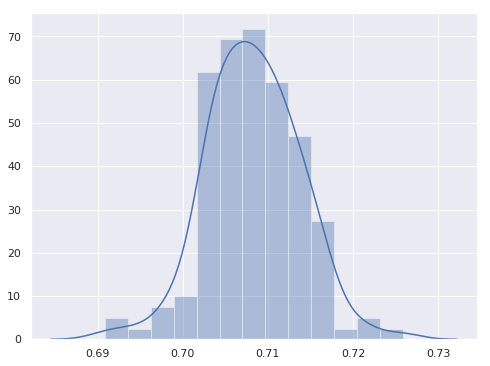

In [62]:
# plot out the distribution of shufflesplit to get performance estimate
plt.figure(figsize=(8,6))
sns.set(font_scale=1)
sns.distributions.distplot(tfidf_scores)
plt.show()

In [144]:
# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(text_df['clean_text'],
                                                    text_df['political_leaning'],
                                                    test_size = 0.2,
                                                    random_state=266)

# Define classifier, over sampler, under sampler and feature selector
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_model = RandomForestClassifier(n_jobs=10, n_estimators=200, max_depth=700, class_weight='balanced_subsample')

# Create pipeline
base_pipe = pipeline.Pipeline([('vectorizer', vectorizer),
                                ('classifier', tfidf_model)])

# Fit pipeline
start_time = time.time()
base_pipe.fit(X_train, y_train)
print('Model training took:', '%s seconds' % '{:.2f}'.format((time.time() - start_time)))

Model training took: 14.75 seconds


In [55]:
# take best estimator from gridsearch and shuffle split x times against train data to get an estimate of performance
cv = model_selection.ShuffleSplit(n_splits=250, test_size=.3)
base_scores = model_selection.cross_val_score(base_pipe, X_train, y_train, cv=cv, n_jobs=-2, scoring='f1_macro')

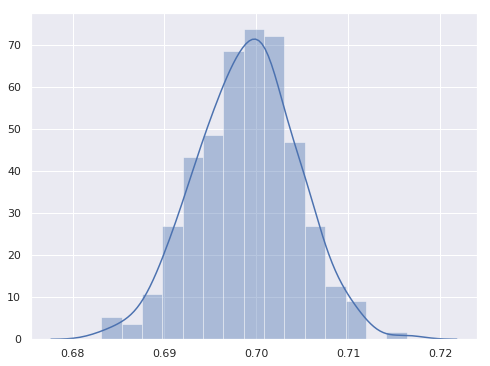

In [57]:
# plot out the distribution of shufflesplit to get performance estimate
plt.figure(figsize=(8,6))
sns.set(font_scale=1)
sns.distributions.distplot(base_scores)
plt.show()

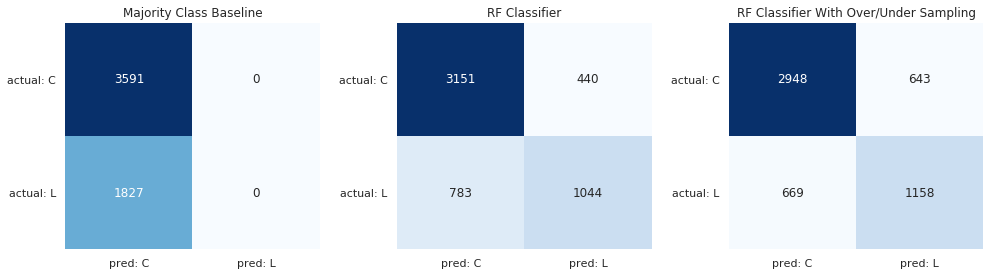

In [274]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))

xlabels = ['pred: C', 'pred: L']
ylabels = ['actual: C', 'actual: L']

sns.heatmap(metrics.confusion_matrix(y_test, np.zeros(y_test.shape[0])),xticklabels=xlabels, yticklabels=ylabels,
            annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax[0])

sns.heatmap(metrics.confusion_matrix(y_test, base_pipe.predict(X_test)),xticklabels=xlabels, yticklabels=ylabels,
            annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax[1])

sns.heatmap(metrics.confusion_matrix(y_test, tfidf_pipe.predict(X_test)), xticklabels=xlabels, yticklabels=ylabels,
            annot=True, fmt='g', cmap='Blues', cbar=False, ax=ax[2])

ax[0].set_title('Majority Class Baseline')
ax[0].tick_params(axis='y', rotation=0)
ax[1].set_title('RF Classifier')
ax[1].tick_params(axis='y', rotation=0)
ax[2].set_title('RF Classifier With Over/Under Sampling')
ax[2].tick_params(axis='y', rotation=0)
    
plt.tight_layout()
plt.show()

In [318]:
print(metrics.classification_report(y_test, np.zeros(y_test.shape[0]), labels=[0, 1], target_names=['Conservative', 'Liberal']))
print(metrics.classification_report(y_test, base_pipe.predict(X_test), labels=[0, 1], target_names=['Conservative', 'Liberal']))
print(metrics.classification_report(y_test, tfidf_pipe.predict(X_test), labels=[0, 1], target_names=['Conservative', 'Liberal']))

              precision    recall  f1-score   support

Conservative       0.66      1.00      0.80      3591
     Liberal       0.00      0.00      0.00      1827

    accuracy                           0.66      5418
   macro avg       0.33      0.50      0.40      5418
weighted avg       0.44      0.66      0.53      5418

              precision    recall  f1-score   support

Conservative       0.80      0.88      0.84      3591
     Liberal       0.70      0.57      0.63      1827

    accuracy                           0.77      5418
   macro avg       0.75      0.72      0.73      5418
weighted avg       0.77      0.77      0.77      5418

              precision    recall  f1-score   support

Conservative       0.82      0.82      0.82      3591
     Liberal       0.64      0.63      0.64      1827

    accuracy                           0.76      5418
   macro avg       0.73      0.73      0.73      5418
weighted avg       0.76      0.76      0.76      5418



# Analysis

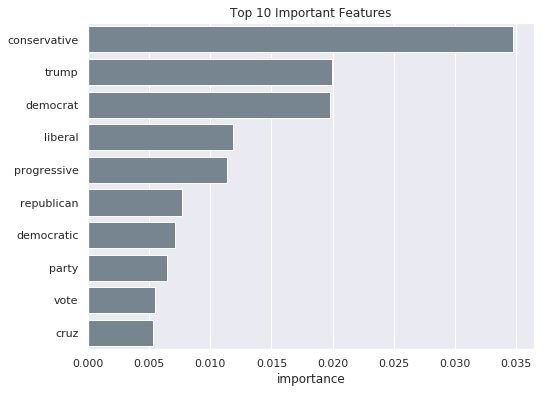

In [147]:
# Get feature importance
feat_importance = pd.DataFrame({'feature':vectorizer.get_feature_names(),
                                'importance':tfidf_model.feature_importances_})
feat_importance = feat_importance.sort_values(by='importance', ascending=False)
feat_importance = feat_importance[~feat_importance['feature'].str.contains('2020')].head(10)

# Plot feature importance
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='importance',
            y='feature', 
            data=feat_importance.head(10), 
            color='#738595',
            ax=ax)

ax.set_ylabel('')
ax.set_title('Top 10 Important Features')
plt.show()

In [196]:
def plot_ice(feat, df, estimator):
    pdp_feat = pdp.pdp_isolate(model=estimator,
                               dataset=df,
                               model_features=list(df.columns), 
                               feature=feat)
    
    fig, axes = pdp.pdp_plot(pdp_feat,
                             feat, 
                             frac_to_plot=0.25, 
                             plot_lines=True,
                             plot_pts_dist=True,
                             figsize=(10,8))
    axes['pdp_ax']['_pdp_ax'].set_ylim(-1, 1)


In [19]:
# Put the tf-idf vectors into a dataframe so it can be used for the PDPs
feature_names = vectorizer.get_feature_names()
X_train_transformed = vectorizer.transform(X_train)
X_train_transformed = X_train_transformed.toarray()
feature_df = pd.DataFrame(X_train_transformed, columns=feature_names)

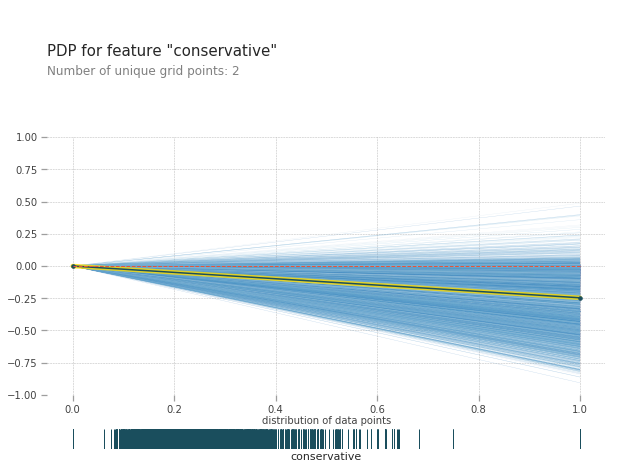

In [197]:
plot_ice('conservative', feature_df, tfidf_model)

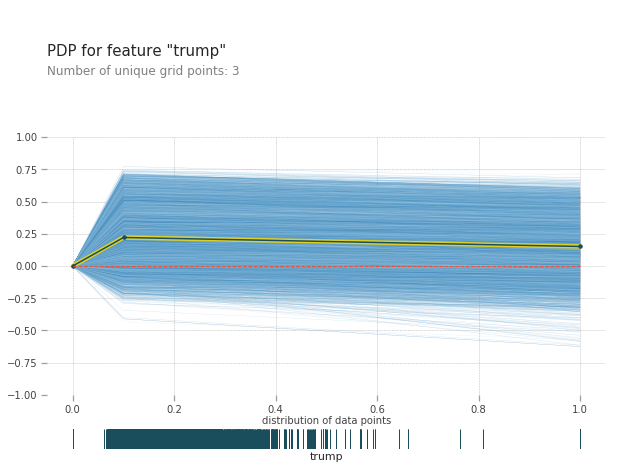

In [199]:
plot_ice('trump', feature_df, tfidf_model)

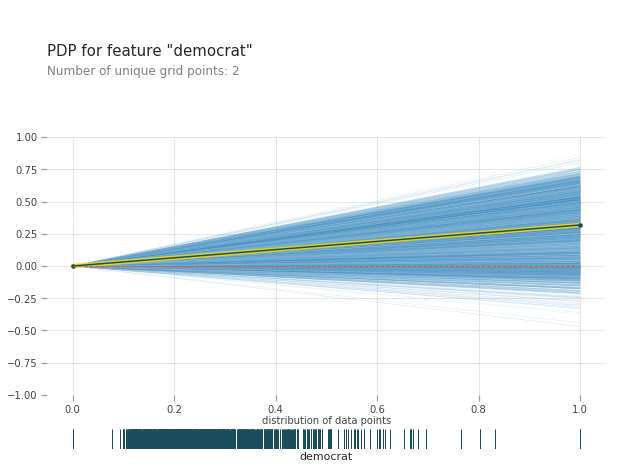

In [200]:
plot_ice('democrat', feature_df, tfidf_model)

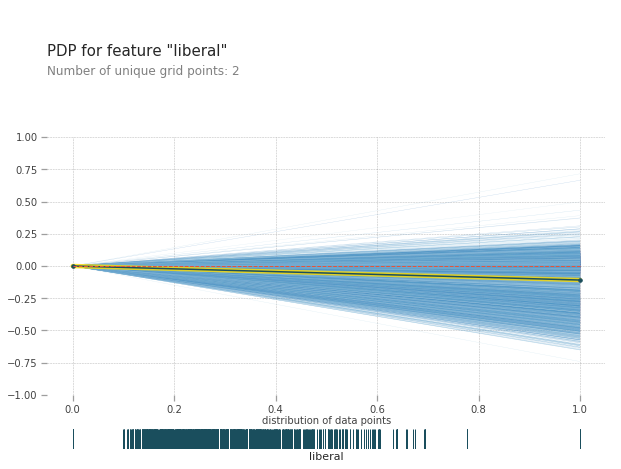

In [198]:
plot_ice('liberal', feature_df, tfidf_model)

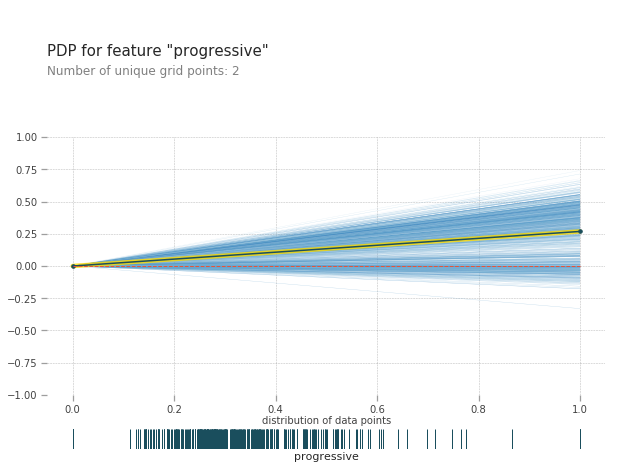

In [152]:
plot_ice('progressive', feature_df, tfidf_model)

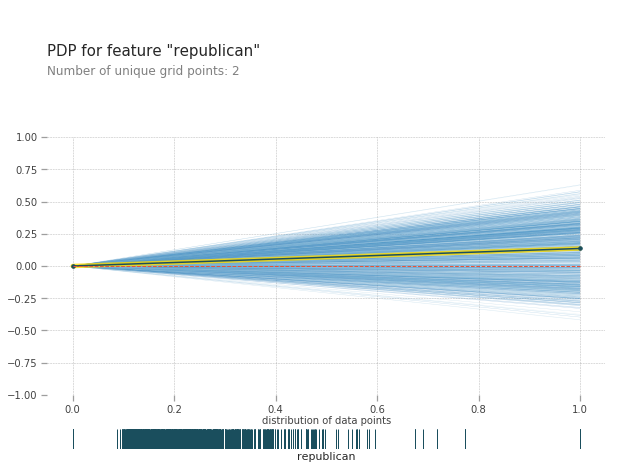

In [153]:
plot_ice('republican', feature_df, tfidf_model)

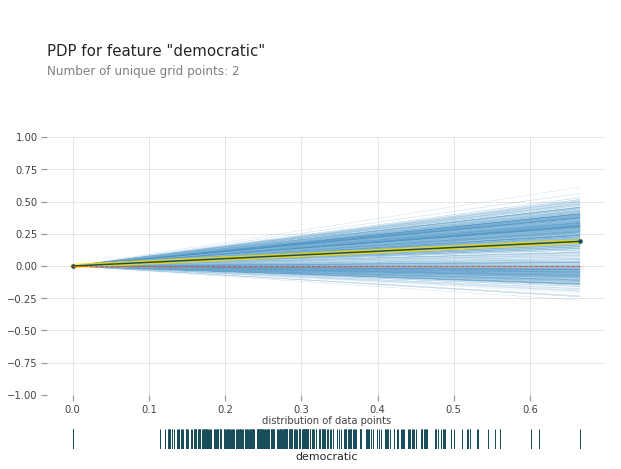

In [154]:
plot_ice('democratic', feature_df, tfidf_model)

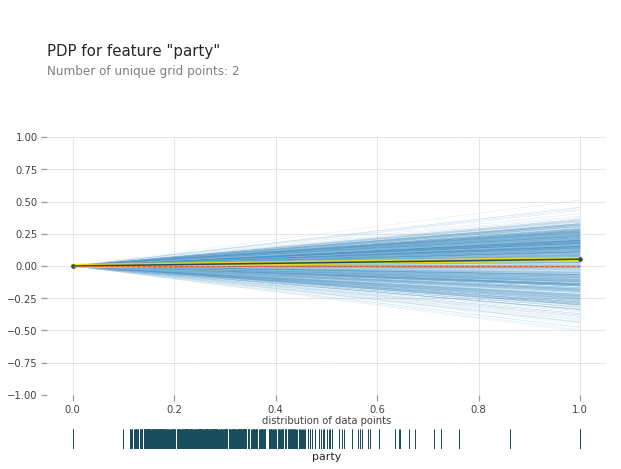

In [155]:
plot_ice('party', feature_df, tfidf_model)

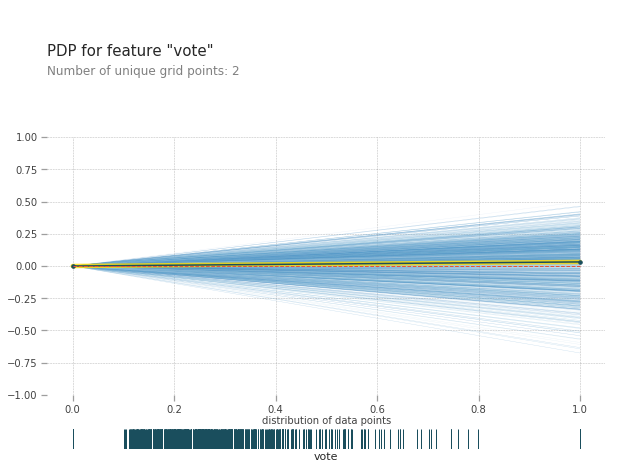

In [156]:
plot_ice('vote', feature_df, tfidf_model)

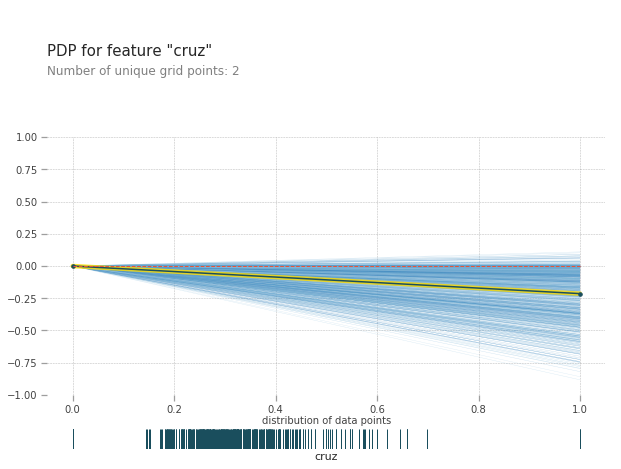

In [157]:
plot_ice('cruz', feature_df, tfidf_model)